In [ ]:
import os
import numpy as np
from skimage import color, io
from skimage.transform import resize

from numpy import asarray
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import load_model
from PIL import Image

from matplotlib import pyplot

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/COVID-19.zip -d /content/dataset

Archive:  /content/gdrive/MyDrive/COVID-19.zip
   creating: /content/dataset/COVID-19/
   creating: /content/dataset/COVID-19/test/
   creating: /content/dataset/COVID-19/test/COVID/
  inflating: /content/dataset/COVID-19/test/COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%0.png  
  inflating: /content/dataset/COVID-19/test/COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%1.png  
  inflating: /content/dataset/COVID-19/test/COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-91.png  
  inflating: /content/dataset/COVID-19/test/COVID/2020.03.12.20034686-p17-91-1.png  
  inflating: /content/dataset/COVID-19/test/COVID/2020.03.12.20034686-p17-91-2.png  
  inflating: /content/dataset/COVID-19/test/COVID/2020.03.22.20040782-p25-1542.png  
 extracting: /content/dataset/COVID-19/test/COVID/2020.03.22.20040782-p25-1543.png  
  inflating: /content/dataset/COVID-19/test/COVID/2020.0

In [ ]:
def load_dataset(path, covid=True):
    X_train, X_val, X_test = [], [], []

    for split in os.listdir(path):
        split_path = os.path.join(path, split)

        if covid:
            covid_path = os.path.join(split_path, 'COVID')
        else:
            covid_path = os.path.join(split_path, 'NonCOVID')

        for image in os.listdir(covid_path):
            image_path = os.path.join(covid_path, image)
            img = color.rgb2gray(io.imread(image_path))

            img_resized = (resize(img, (128, 128), anti_aliasing=True))
            X = expand_dims(img_resized, axis=-1)

            if split == 'train':
                X_train.append(X/255)
            elif split == 'val':
                X_val.append(X/255)
            else:
                X_test.append(X/255)

    X_train, X_val, X_test = np.stack(X_train), np.stack(X_val), np.stack(X_test)
    return X_train, X_val, X_test

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(128,128,1)):
  model = Sequential()
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
  model = Sequential()
  # foundation for 32x32 image
  n_nodes = 128 * 32 * 32
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((32, 32, 128)))
  # upsample to 64x64
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 128x128
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
  return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
# load and prepare mnist training images
"""def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X"""

"def load_real_samples():\n\t# load mnist dataset\n\t(trainX, _), (_, _) = load_data()\n\t# expand to 3d, e.g. add channels dimension\n\tX = expand_dims(trainX, axis=-1)\n\t# convert from unsigned ints to floats\n\tX = X.astype('float32')\n\t# scale from [0,255] to [0,1]\n\tX = X / 255.0\n\treturn X"

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [ ]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray')
	# save plot to file
	filename = '/content/gdrive/MyDrive/generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = '/content/gdrive/MyDrive/noncovid_generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=3301, n_batch=32):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  d_loss_history, g_loss_history = [], []
  # manually enumerate epochs
  for i in range(n_epochs):
  # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # create training set for the discriminator
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      # update discriminator model weights
      d_loss, _ = d_model.train_on_batch(X, y)
      d_loss_history.append(d_loss)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      g_loss_history.append(g_loss)
      # summarize loss on this batch
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
      # evaluate the model performance, sometimes
    if (i+1) % 300 == 0 and i > 1900:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)
      numpy_d_loss_history = np.array(d_loss_history)
      numpy_g_loss_history = np.array(g_loss_history)
      np.savetxt("/content/gdrive/MyDrive/d_loss_history.txt", numpy_d_loss_history, delimiter=",")
      np.savetxt("/content/gdrive/MyDrive/g_loss_history.txt", numpy_g_loss_history, delimiter=",")

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
X_train, X_val, X_test = load_dataset('/content/dataset/COVID-19', covid=False)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# train model
train(g_model, d_model, gan_model, X_train, latent_dim)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
>2588, 5/7, d=0.709, g=0.710
>2588, 6/7, d=0.704, g=0.748
>2588, 7/7, d=0.688, g=0.667
>2589, 1/7, d=0.688, g=0.713
>2589, 2/7, d=0.683, g=0.702
>2589, 3/7, d=0.702, g=0.614
>2589, 4/7, d=0.716, g=0.688
>2589, 5/7, d=0.712, g=0.730
>2589, 6/7, d=0.690, g=0.698
>2589, 7/7, d=0.695, g=0.704
>2590, 1/7, d=0.687, g=0.722
>2590, 2/7, d=0.690, g=0.698
>2590, 3/7, d=0.689, g=0.713
>2590, 4/7, d=0.675, g=0.737
>2590, 5/7, d=0.709, g=0.781
>2590, 6/7, d=0.708, g=0.689
>2590, 7/7, d=0.697, g=0.686
>2591, 1/7, d=0.700, g=0.674
>2591, 2/7, d=0.701, g=0.709
>2591, 3/7, d=0.702, g=0.697
>2591, 4/7, d=0.698, g=0.695
>2591, 5/7, d=0.703, g=0.725
>2591, 6/7, d=0.707, g=0.716
>2591, 7/7, d=0.709, g=0.660
>2592, 1/7, d=0.692, g=0.765
>2592, 2/7, d=0.690, g=0.653
>2592, 3/7, d=0.661, g=0.744
>2592, 4/7, d=0.660, g=0.736
>2592, 5/7, d=0.696, g=0.664
>2592, 6/7, d=0.703, g=0.850
>2592, 7/7, d=0.673, g=0.635
>2593, 1/7, d=0.648, g=0.790
>2593, 2/7, d=0.730, g=0.

In [ ]:
g_model = load_model('/content/gdrive/MyDrive/covid_generator_model_3300.h5')

In [ ]:
all = g_model.predict(generate_latent_points(100, 50))

In [ ]:
def make_image(data, outputname, size=(1, 1), dpi=128):
    fig = plt.figure()
    fig.set_size_inches(size)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.set_cmap('gray')
    ax.imshow(data, aspect='equal')
    plt.savefig(outputname, dpi=dpi)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


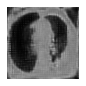

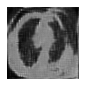

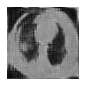

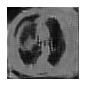

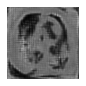

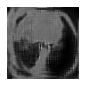

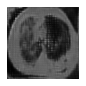

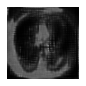

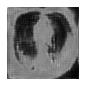

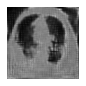

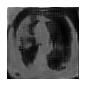

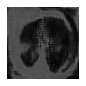

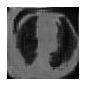

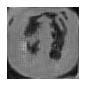

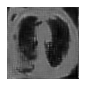

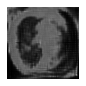

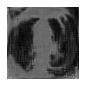

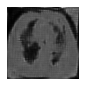

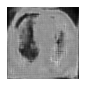

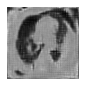

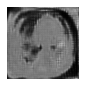

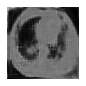

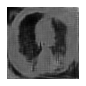

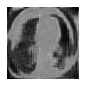

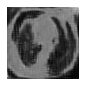

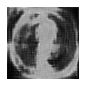

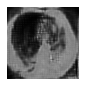

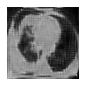

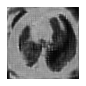

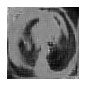

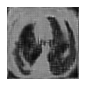

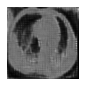

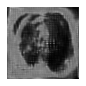

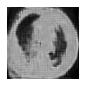

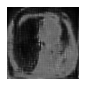

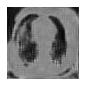

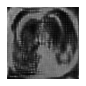

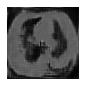

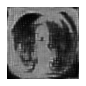

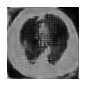

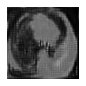

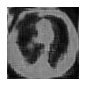

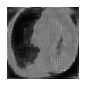

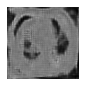

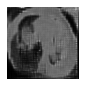

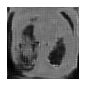

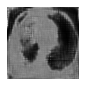

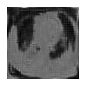

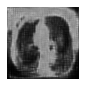

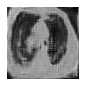

In [ ]:
import matplotlib.pyplot as plt

if not os.path.exists("generated_covid"):
  os.mkdir("generated_covid")
for (idx), im in enumerate(all):
  make_image(im[:,:,0], 'generated_covid/generated_covid{:0>3}.png'.format(idx))

In [ ]:
g_model = load_model('/content/gdrive/MyDrive/noncovid_generator_model_3300.h5')

In [ ]:
all = g_model.predict(generate_latent_points(100, 50))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


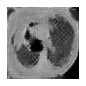

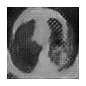

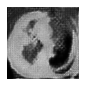

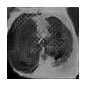

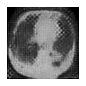

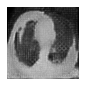

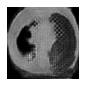

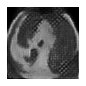

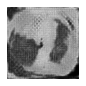

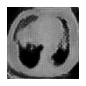

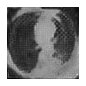

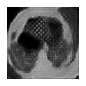

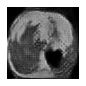

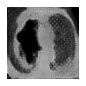

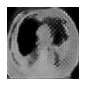

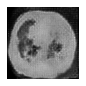

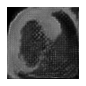

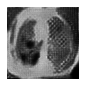

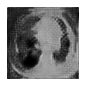

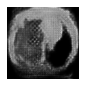

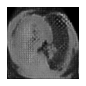

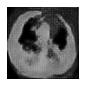

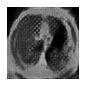

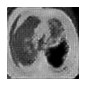

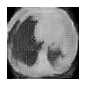

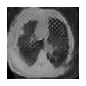

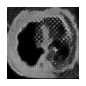

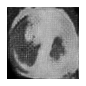

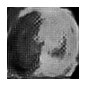

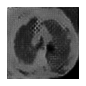

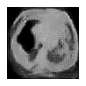

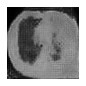

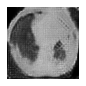

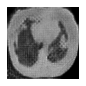

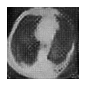

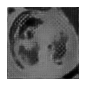

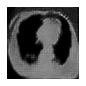

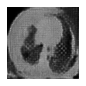

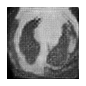

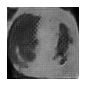

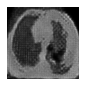

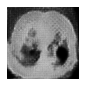

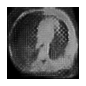

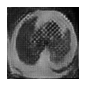

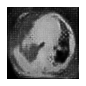

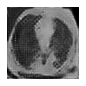

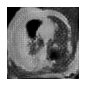

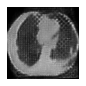

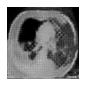

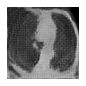

In [ ]:
import matplotlib.pyplot as plt

if not os.path.exists("generated_noncovid"):
  os.mkdir("generated_noncovid")
for (idx), im in enumerate(all):
  make_image(im[:,:,0], 'generated_noncovid/generated_noncovid{:0>3}.png'.format(idx))

In [ ]:
!zip -r /content/gdrive/MyDrive/gen_noncovid_3300_n.zip /content/generated_noncovid3300

	zip warning: name not matched: /content/generated_noncovid3300

zip error: Nothing to do! (try: zip -r /content/gdrive/MyDrive/gen_noncovid_3300_n.zip . -i /content/generated_noncovid3300)


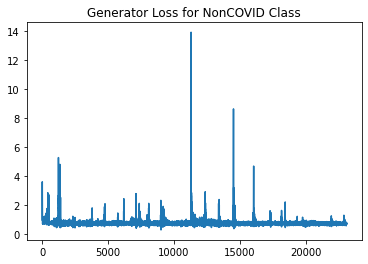

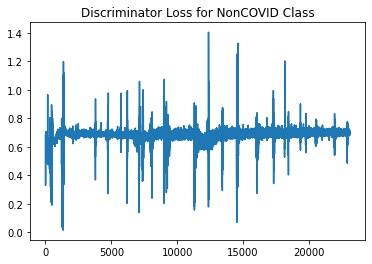

In [ ]:
import matplotlib.pyplot as plt
g_loss_his = np.loadtxt("/content/gdrive/MyDrive/g_loss_history.txt")
plt.plot(g_loss_his)
plt.title("Generator Loss for NonCOVID Class")
plt.show()

d_loss_his = np.loadtxt("/content/gdrive/MyDrive/d_loss_history.txt")
plt.plot(d_loss_his)
plt.title("Discriminator Loss for NonCOVID Class")
plt.show()